# Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods
# *Choosing the right hotel to stay in*

Author: Radoslaw Cholewinski

Date: May 2020

Below the code for the capstone project is provided. This code loads location data for recommended hotels in Naples, Italy, explores the neighborhood of each hotel and clusters each hotel into a group based on categories of nearby venues. 

Let's start with importing all the necessary libraries and setting up the login credentials for Foursquare.

In [2]:
# import libraries
import requests # library to handle requests
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium # map rendering library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('All libraries successfully imported!')

# Foursquare login credentials
CLIENT_ID = 'JKXB1NZHLEIDGDDJCWLAFW34C2MO2U4INCTU5DP2XYWDGPMQ' # Foursquare ID
CLIENT_SECRET = 'S4JNYT15YBGXGKLBGOBDQEXNS5DAD1U41OQ3K3N23JZTH02Q' # Foursquare Secret
VERSION = '20200516' #  API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

All libraries successfully imported!
My credentails:
CLIENT_ID: JKXB1NZHLEIDGDDJCWLAFW34C2MO2U4INCTU5DP2XYWDGPMQ
CLIENT_SECRET:S4JNYT15YBGXGKLBGOBDQEXNS5DAD1U41OQ3K3N23JZTH02Q


Create a request to get the list of recommended hotels in Naples and send it to the Foursquare API.

In [3]:
# set the url parameters
near = 'Naples, IT' # could be anywhere on earth
categoryId = '4bf58dd8d48988d1fa931735' # this is Fourquare code for hotels  

url = 'https://api.foursquare.com/v2/venues/explore?near={}&categoryId={}&client_id={}&client_secret={}&v={}'.format(near, categoryId,
    CLIENT_ID, CLIENT_SECRET, VERSION)

# send the request
results = requests.get(url).json()
n_results = results['response']['totalResults'] #  number of results
n_results

98

The request returned 98 results, which is more than the maximum declared by the Foursquare API. Let's set a limit for the number of results to 100 and see how many records we can actually retrieve.

In [4]:
# narrow the search
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?near={}&categoryId={}&client_id={}&client_secret={}&v={}&limit={}'.format(near, categoryId,
    CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT)

# send the request
results = requests.get(url).json()
len(results['response']['groups'][0]['items'])

89

Without any further experimentation with the API parameters, we can retrieve from Foursquare 89 recommended hotels, which in my opinion is pretty sufficient to choose the right one. 

Store location data of recommended hotels in a data frame:

In [5]:
# create a data frame with all hotels
hotels = []

# loop over all results to extract the location data
for result in results['response']['groups'][0]['items']:
    hotel_name = result['venue']['name']
    hotel_lat = result['venue']['location']['lat']
    hotel_lng = result['venue']['location']['lng']
    hotel = [hotel_name, hotel_lat, hotel_lng]
    hotels.append(hotel)
    
hotels = pd.DataFrame(hotels, columns=['Name', 'Lattitude', 'Longitude'])
hotels.head()

,Name,Lattitude,Longitude
0,Hotel Piazza Bellini,40.850463,14.251416
1,Grand Hotel Vesuvio,40.829892,14.248090
2,Romeo Hotel Naples,40.840612,14.255748
3,Palazzo Decumani,40.848995,14.259077
4,Palazzo Alabardieri,40.834790,14.241711


Check if the 'for' loop was successful by inspecting the shape of the data frame:

In [6]:
hotels.shape

(89, 3)

Ok, we have 89 results! 

Now let's explore the neighborhood of each hotel. I use the function defined in the Week 3 lab, which sends an 'explore' query to Foursquare.

In [7]:
# define a function to get recommended venues

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hotel Name', 
                  'Hotel Latitude', 
                  'Hotel Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The function takes as arguments: a list of hotel names and lists of hotel coordinates.

In [8]:
# get the recommended venues for each hotel
hotel_venues = getNearbyVenues(names=hotels['Name'], latitudes = hotels['Lattitude'], longitudes = hotels['Longitude'])
hotel_venues

,Hotel Name,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hotel Piazza Bellini,40.850463,14.251416,Libreria Berisio,40.849405,14.251149,Bookstore
1,Hotel Piazza Bellini,40.850463,14.251416,Hotel Piazza Bellini,40.850463,14.251416,Hotel
2,Hotel Piazza Bellini,40.850463,14.251416,Piazza Vincenzo Bellini,40.849843,14.252102,Plaza
3,Hotel Piazza Bellini,40.850463,14.251416,Piazza Dante,40.849016,14.250188,Plaza
4,Hotel Piazza Bellini,40.850463,14.251416,Spazio Nea,40.850178,14.252068,Art Gallery
...,...,...,...,...,...,...,...
3595,Hotel Augustus,40.848831,14.475788,San Michele Food e Drink,40.845935,14.471990,Pizza Place
3596,Rooms Rent Vesuvio Bed & breakfast,40.851483,14.341922,Cirelli Bakery,40.847685,14.339153,Bakery
3597,Rooms Rent Vesuvio Bed & breakfast,40.851483,14.341922,Rooms Rent Vesuvio Bed & breakfast,40.851483,14.341922,Bed & Breakfast
3598,Rooms Rent Vesuvio Bed & breakfast,40.851483,14.341922,"Circumvesuviana Vesuvio de Meis (L3, L4)",40.849579,14.339777,Light Rail Station


The function returned 3600 venues, which means that each hotel has on average 40 venues in its neighborhood. 

Now let's turn to the one-hot encoding to create a dummy variable for each venue type.

In [10]:
# one hot encoding
venues_onehot = pd.get_dummies(hotel_venues[['Venue Category']], prefix='', prefix_sep='')

# add hotel name column back to dataframe
venues_onehot.insert(loc = 0, column = 'Hotel Name', value = hotel_venues['Hotel Name'].values)

venues_onehot.head()

,Hotel Name,Airport,Airport Service,Aquarium,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,...,Tennis Court,Theater,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Zoo
0,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hotel Piazza Bellini,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hotel Piazza Bellini,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's summarize entries for each hotel by grouping them and summing all the entries in a given category. That shows how many venues of a given category are located in hotel's neighborhood. Before proceeding with clustering, it's important to normalize these sums. While there can be lots of Italian restaurants near a single hotel, there will be zero or one airport in its vicinity. 

In the week 3 lab example, the number of occurrences of a given category was normalized by the total number of venues in a neighborhood. While that is a smart approach for an analysis of neighborhoods (areas), it gets more complicated with hotels (single points). There can be e.g. only one venue in a hotel's vicinity, say one restaurant, but that doesn't mean the hotel's neighborhood is densely populated with restaurants. 

Let's divide these sums by the largest number of occurrences of a given category for all hotels. That approach yields a 'score', whether there are relatively many or relatively few venues of a given category in a hotel's neighborhood. 

In [11]:
# compute the number of venues in each category for a given hotel and normalize it by the largest element

summary = venues_onehot.groupby('Hotel Name').sum()
summary = summary.div(summary.max(axis=0)).reset_index()
summary.head()

,Hotel Name,Airport,Airport Service,Aquarium,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,...,Tennis Court,Theater,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Zoo
0,Albergo Palazzo Decumani Hotel Naples,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.666667,0.0
1,American Park Hotel,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0
2,Apart Hotel Plebiscito,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.375,0.0,0.0,0.000000,0.0
3,Apatrhotel Plebiscito,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.375,0.0,0.0,0.000000,0.0
4,B&B Albachiara,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.0


Extract the categories with highest score (most common) for each hotel:

In [12]:
# function to return venues with the highest sccore
def return_most_common_venues(row, num_top_venues):
    
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# display venues with the highest score
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hotel Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hotels_sorted = pd.DataFrame(columns=columns)
hotels_sorted['Hotel Name'] = summary['Hotel Name']

for ind in np.arange(summary.shape[0]):
    hotels_sorted.iloc[ind, 1:] = return_most_common_venues(summary.iloc[ind, :], num_top_venues)

hotels_sorted.head()

,Hotel Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Albergo Palazzo Decumani Hotel Naples,Fried Chicken Joint,Deli / Bodega,Comic Shop,Sandwich Place,Pizza Place
1,American Park Hotel,Nightclub,Hotel,Zoo,Cupcake Shop,Farmers Market
2,Apart Hotel Plebiscito,Palace,Speakeasy,History Museum,Fish Market,Juice Bar
3,Apatrhotel Plebiscito,Palace,Speakeasy,History Museum,Fish Market,Juice Bar
4,B&B Albachiara,Soccer Stadium,Burger Joint,Coffee Shop,Supermarket,Mediterranean Restaurant


After the venue categories have been transformed into normalized features, it's possible to cluster all hotels using the k-means algorithm.

In [13]:
# set number of clusters
kclusters = 4

hotel_clusters = summary.drop('Hotel Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hotel_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 1, 0, 3, 3, 1, 3], dtype=int32)

In [14]:
# add clustering labels
hotels_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [15]:
# merge hotel location data with cluster labels and the most common venues
hotels_merged = hotels.merge(hotels_sorted,left_on='Name',right_on='Hotel Name')
hotels_merged.drop(columns='Hotel Name',inplace=True)
hotels_merged.head()

,Name,Lattitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Hotel Piazza Bellini,40.850463,14.251416,0,Historic Site,Greek Restaurant,Deli / Bodega,Pub,History Museum
1,Grand Hotel Vesuvio,40.829892,14.248090,1,Castle,Garden,Diner,Cafeteria,Island
2,Romeo Hotel Naples,40.840612,14.255748,2,Campanian Restaurant,Sporting Goods Shop,Gourmet Shop,Convenience Store,Deli / Bodega
3,Palazzo Decumani,40.848995,14.259077,0,Fried Chicken Joint,Deli / Bodega,Comic Shop,Sandwich Place,Pizza Place
4,Palazzo Alabardieri,40.834790,14.241711,0,Bistro,Park,Cupcake Shop,Road,Beer Bar


Visualize resulting clusters:

In [16]:
##### create map
map_clusters = folium.Map(location=[40.85, 14.30], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotels_merged['Lattitude'], hotels_merged['Longitude'], hotels_merged['Name'], hotels_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Check what's in cluster #1:

In [17]:
hotels_sorted[hotels_sorted['Cluster Labels']==1]

,Cluster Labels,Hotel Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,1,American Park Hotel,Nightclub,Hotel,Zoo,Cupcake Shop,Farmers Market
2,1,Apart Hotel Plebiscito,Palace,Speakeasy,History Museum,Fish Market,Juice Bar
3,1,Apatrhotel Plebiscito,Palace,Speakeasy,History Museum,Fish Market,Juice Bar
4,1,B&B Albachiara,Soccer Stadium,Burger Joint,Coffee Shop,Supermarket,Mediterranean Restaurant
8,1,B&B Mergellina,Waterfront,Movie Theater,Beach,Mexican Restaurant,Convenience Store
10,1,Best Western San Germano,Gym,Spa,Supermarket,Restaurant,Hotel
11,1,Capo Inn Suites,Gym / Fitness Center,Gym,Convenience Store,Pizza Place,Café
12,1,Capodichino International Hotel,Fast Food Restaurant,Furniture / Home Store,Rest Area,Rental Car Location,Dessert Shop
17,1,Fly Boutique Hotel,Food & Drink Shop,Pizza Place,Plaza,Food,Clothing Store
19,1,Grand Hotel Capodimonte,Museum,Cemetery,Fast Food Restaurant,Plaza,Pizza Place


To get a sense in what terms clusters differ from each other, it's useful to create a summary of all hotel clusters listing the venue categories with the highest combined (mean) score.

In [18]:
# create a cluster summary by computing the mean score for all hotels in a given cluster
# add the cluster label to 'summary' data frame
cluster_summary = summary.merge(hotels_sorted, on="Hotel Name").groupby('Cluster Labels').mean().reset_index()

# get venues with the highest mean score for each cluster
# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
clusters_sorted = pd.DataFrame(columns=columns)
clusters_sorted['Cluster Labels'] = cluster_summary['Cluster Labels']

for ind in np.arange(cluster_summary.shape[0]):
    clusters_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_summary.iloc[ind, :], num_top_venues)

clusters_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Deli / Bodega,Sandwich Place,Fried Chicken Joint,Comic Shop,Plaza
1,1,Pizza Place,Convenience Store,Diner,Light Rail Station,Italian Restaurant
2,2,Asian Restaurant,Convenience Store,Fountain,Hotel,Hostel
3,3,Bakery,Food & Drink Shop,Gift Shop,Candy Store,Food


One could experiment with a value of *k*. The larger the number of clusters, the lower the intra-cluster dispersion, but clusters may become too similar or too small or lack a clear pattern of differentiation.

In [19]:
# find the optimum value of k
inertia = []
hotel_clusters = summary.drop('Hotel Name', 1)
kvalues = np.arange(10)+1

# run k-means clustering
for k in kvalues:
    kclusters = k+1
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hotel_clusters)
    inertia.append(kmeans.inertia_)

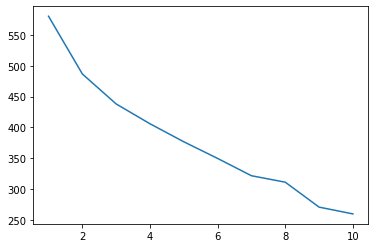

In [20]:
plt.plot(kvalues, inertia)
plt.show()

The steepest decline in the inertia score is recorded for *k* between 2 and 7. After some experimentation, *k* was set too 4 (see the report for details). The cluster of my choice is #1 (pizza places, convenience stores, Italian restaurants and public transport access). 

Visualize the location of cluster #1 hotels.

In [21]:
my_cluster = 1

map_clusters = folium.Map(location=[40.85, 14.30], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotels_merged['Lattitude'], hotels_merged['Longitude'], hotels_merged['Name'], hotels_merged['Cluster Labels']):
    if cluster == my_cluster:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

map_clusters

It appears that hotels in that cluster are located in quite different areas of the city, but they are all close to pizza

#find optimum k by checking if new clusters make sense (first three are grouped together, fourth one are others, when you add five it consists only of two